In [3]:
# Import Library dan tool yang dibutuhkan 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
# import seaborn as sns

In [4]:
def dice_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [6]:
# Image Preprocessing

image_list=os.listdir('Skin Cancer/Training_Data')
image_list=[filename.split(".")[0]for filename in image_list]
    
def get_segmented_img(img,n_classes):
    # membuat label pada gambar segmen
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]

    seg_labels[:,:,0]=(img!=0).astype(int)
    return seg_labels

def preprocess_img(img):
  # Ubah ukuran image sesuai dengan kebutuhan
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
  
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'Skin Cancer/Training_Data/{fn}.jpg',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'Skin Cancer/Training_GroundTruth/{fn}_Segmentation.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)


In [7]:
print('Skin Cancer/Training_GroundTruth/'+image_list[10]+'_Segmentation.png')

Skin Cancer/Training_GroundTruth/ISIC_0000016_Segmentation.png


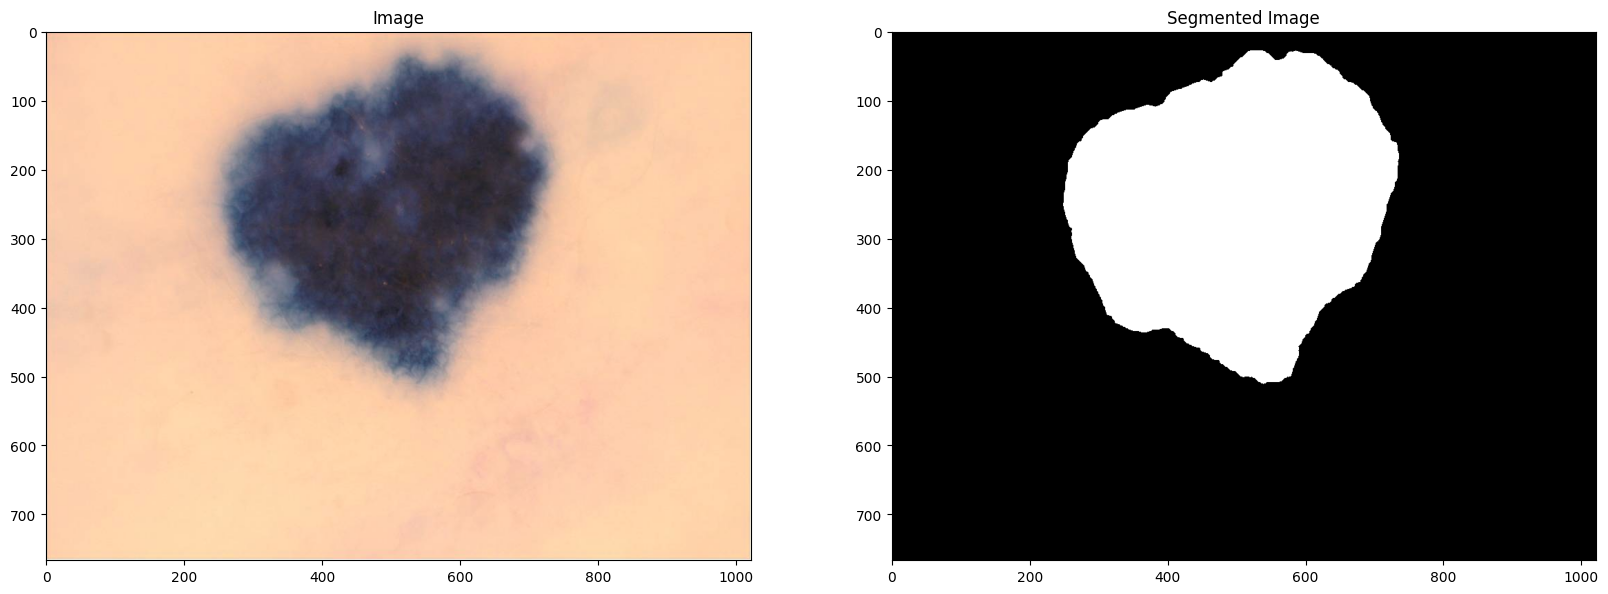

In [8]:
# test Image yang dikeluarkan serta segmentasinya
img=cv2.imread('Skin Cancer/Training_Data/'+image_list[10]+'.jpg',1)
seg=cv2.imread('Skin Cancer/Training_GroundTruth/'+image_list[10]+'_Segmentation.png',1)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(seg,cmap='gray')
plt.title('Segmented Image')
plt.show()

In [9]:
# 
def residual_block(x, temp, conv):
    # a simple residual block with two convolutional layers
    
    y = Conv2D(temp, 1, activation='relu', padding='same')(x)
    y = BatchNormalization(axis = 3)(y)
    y = Add()([y, conv])
    return y


def unet(pretrained_weights = None,input_size = (512,512,1)):
  inputs = Input(input_size)
  temp1 = 64

  conv1 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  # conv1 = BatchNormalization(axis=3)(conv1)
  conv1 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  res = residual_block(inputs, temp1, conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(res)

  temp2 = 128
  conv2 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = BatchNormalization(axis=3)(conv2)
  conv2 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  res = residual_block(pool1, temp2, conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(res)

  temp3 = 256
  conv3 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  # conv3 = BatchNormalization(axis=3)(conv3)
  conv3 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  res = residual_block(pool2, temp3, conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(res)
  

  temp4 = 512
  conv4 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = BatchNormalization(axis=3)(conv4)
  conv4 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  res = residual_block(pool3, temp4, drop4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(res)

  temp5 = 1024
  conv5 = Conv2D(temp5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  # conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Conv2D(temp5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  drop5 = residual_block(pool4, temp5, drop5)


  up6 = Conv2D(temp4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = BatchNormalization(axis=3)(conv6)
  conv6 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  conv6 = residual_block(merge6, temp4, conv6)

  up7 = Conv2D(temp3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  # conv7 = BatchNormalization(axis=3)(conv7)
  conv7 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  conv7 = residual_block(merge7, temp3, conv7)

  up8 = Conv2D(temp2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = BatchNormalization(axis=3)(conv8)
  conv8 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  conv8 = residual_block(merge8, temp2, conv8)

  up9 = Conv2D(temp1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  # conv9 = BatchNormalization(axis=3)(conv9)
  conv9 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = residual_block(merge9, 2, conv9)

  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 512, 512, 64  128         ['input_1[0][0]']                
                                )                                                             

c:\Users\Nabil\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 1024  9438208     ['conv2d_12[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 1024  4096       ['conv2d_14[0][0]']              
 rmalization)                   )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 32, 32, 1024  0           ['conv2d_13[0][0]']              
                                )                                                                 
                                                                                                  
 add_4 (Ad

In [10]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

In [11]:
print (np.shape(file_train),np.shape(file_test))

(675,) (225,)


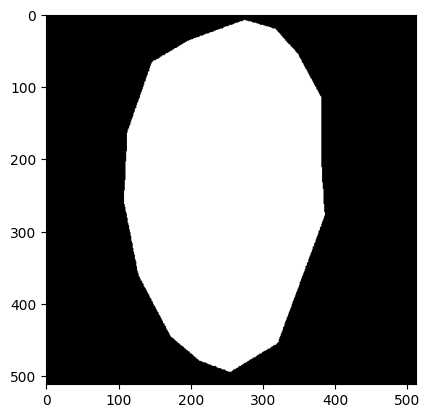

In [12]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [13]:
model.fit(batch_generator(file_train,2,2),epochs=10,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),validation_steps=200,shuffle=1)

Epoch 1/10
 89/100 [=========================>....] - ETA: 6:16 - loss: 0.5770 - accuracy: 0.6964

In [ ]:
def gating_signal(input, out_size):
    x = Conv2D(out_size, (1, 1), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def repeat_elem(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)
                          
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

In [ ]:
def att_res_unet(pretrained_weights = None,input_size = (512,512,1)):
  inputs = Input(input_size)
  temp1 = 64

  conv1 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  # conv1 = BatchNormalization(axis=3)(conv1)
  conv1 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  res1 = residual_block(inputs, temp1, conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(res1)

  temp2 = 128
  conv2 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = BatchNormalization(axis=3)(conv2)
  conv2 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  res2 = residual_block(pool1, temp2, conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(res2)

  temp3 = 256
  conv3 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  # conv3 = BatchNormalization(axis=3)(conv3)
  conv3 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  res3 = residual_block(pool2, temp3, conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(res3)
  

  temp4 = 512
  conv4 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = BatchNormalization(axis=3)(conv4)
  conv4 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  res4 = residual_block(pool3, temp4, drop4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(res4)

  temp5 = 1024
  conv5 = Conv2D(temp5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  # conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Conv2D(temp5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  drop5 = residual_block(pool4, temp5, drop5)

  gating_6 = gating_signal(drop5, 512)
  att_6 = attention_block(res4, gating_6,512)
  up6 = Conv2D(temp4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = BatchNormalization(axis=3)(conv6)
  conv6 = Conv2D(temp4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  conv6 = residual_block(merge6, temp4, conv6)

  gating_7 = gating_signal(conv6, 256)
  att_7 = attention_block(res3, gating_7,256)
  up7 = Conv2D(temp3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  # conv7 = BatchNormalization(axis=3)(conv7)
  conv7 = Conv2D(temp3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  conv7 = residual_block(merge7, temp3, conv7)

  gating_8 = gating_signal(conv7, 128)
  att_8 = attention_block(res2, gating_8, 128)
  up8 = Conv2D(temp2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = BatchNormalization(axis=3)(conv8)
  conv8 = Conv2D(temp2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  conv8 = residual_block(merge8, temp2, conv8)

  gating_7 = gating_signal(conv8, 64)
  att_7 = attention_block(res1, gating_7, 64)
  up9 = Conv2D(temp1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  # conv9 = BatchNormalization(axis=3)(conv9)
  conv9 = Conv2D(temp1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = residual_block(merge9, 2, conv9)

  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model_att_resunet= att_res_unet()
model_att_resunet.summary()

In [ ]:
model_att_resunet.fit(batch_generator(file_train,2,2),epochs=10,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),validation_steps=200,shuffle=1)

In [ ]:
img=cv2.imread(f'/content/drive/MyDrive/Deep Learning/Skin Cancer/Training_Data/ISIC_0000000.jpg',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)

In [ ]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [ ]:
# copy = img.copy()
# plt.imshow(copy, cmap="gray")

In [ ]:
plt.imsave('test_img_mask.JPG',pred)

In [ ]:
coordinates=[]

In [ ]:
import cv2
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/2.JPG')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # Mencari bordir kotak
    x, y, w, h = cv2.boundingRect(c)
    # Bordir kotak divisualisasikan dengan warna merah
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

plt.imshow(ori_img)